## Week 3: CNN Cancer Detection Kaggle Mini-Project

### Problem Description
The "Histopathologic Cancer Detection" challenge on Kaggle is a **Binary Image Classification** problem. The project's goal is to develop a machine learning model to **automatically identify** the presence of **metastatic cancer** in small image patches derived from larger digital pathology scans.

* **Required Output:** The model must predict a **binary label** for each image patch:
    * **1 (Positive):** The image patch contains at least one pixel of tumor tissue within the center $32 \times 32$ region.
    * **0 (Negative):** The image patch does not contain tumor tissue in the center $32 \times 32$ region.


### Data Description
The data for this competition is a slightly modified version of the well-known **PatchCamelyon (PCam)** benchmark dataset.
* **Modification:** The original PCam dataset contained duplicate images due to its probabilistic sampling method. The version presented on Kaggle **does not contain duplicates**, though the core data and splits remain consistent with the PCam 

#### Size and Structure
* **Total Files:** **277,485** image files.
* **Total Size:** **7.76 GB**.
* **File Types:** **`.tif`** image files and a **`.csv`** label file.

#### Dimensions and Format
* **Image Format:** The files are in `.tif` (Tagged Image File Format), a common format in medical imaging.
* **Patch Size:** Each image patch has a dimension of $96 \times 96$ pixels.
* **Color Channels:** The images are **RGB** (3 color channels), resulting in a tensor dimension of **$(96, 96, 3)$** per image.
* **Labeling Rule:** The positive label is determined by the presence of tumor tissue within the **center $32 \times 32$ region** of the patch. The outer region serves as padding to enable fully-convolutional models without zero-padding.

### Proposed Approach
The challenge presents a relatively **large dataset** ($7.76\text{ GB}$ with $277,485$ images) compared to a standard student project.
Therefore, the chosen primary solution will utilize **Transfer Learning** with **Freezing Initial Layers** based on pre-trained **Deep Convolutional Neural Networks (CNNs)** from the ImageNet dataset. The models selected for analysis are: **ResNet50** and **VGG16 (or VGG19)**.

## 🔬 1. Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data 

### 2.1. Data Cleaning and Integrity

A crucial step of initial data cleaning was **pre-performed by the competition host**. This inherent cleaning ensures high data integrity regarding duplicates, allowing the project to focus on pre-processing required for Deep Learning rather than heavy data cleaning.

### 1.2. Class Distribution Analysis

**Procedure:** We load the `train_labels.csv` file and count the occurrence of each label (0 and 1).
* **Visualization:** The bar plot below clearly illustrates this distribution: The Non-Cancer class (Label 0) having a higher representation than the Cancer class (Label 1). The analysis shows a slight **class imbalance**. 

### 1.3. Visual Inspection of Image Patches
* **Visualization:** A grid of sample images is generated to show the visual difference between the two classes.

TensorFlow version: 2.16.2
--- 2.1. Load and Inspect Labels ---
Total number of training samples: 220025

First 5 rows of the dataset:
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0

--- 2.2. Class Distribution ---
label
0    130908
1     89117
Name: count, dtype: int64


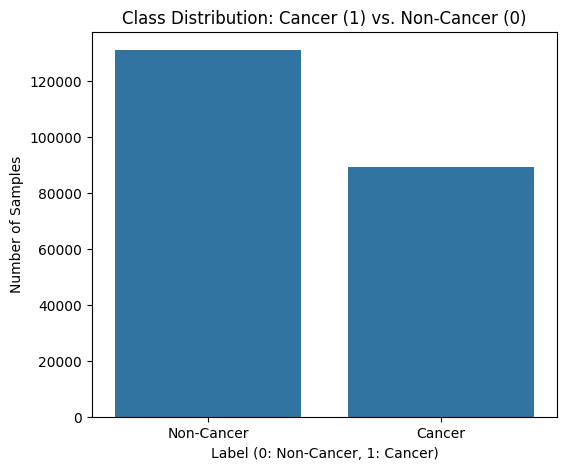

Observation: The data shows a slight class imbalance.

--- 3. Image Visualization ---
Error: Image file not found for ID 941ffe73059292e0effd4e81ca9363c117afc2f4
Error: Image file not found for ID 9464cf403653088420cdb78acacd8cf7fa2255e4
Error: Image file not found for ID a9f7f612736ebf2fb47cd83ce0c368d3a480aeb2
Error: Image file not found for ID c4f9ad1baf7755d52b2c37448ea3773c8520ee7d
Error: Image file not found for ID ab999642f7ae64e93cb79607a32b7510784b2472
Error: Image file not found for ID c7160b615fc6b9527d61232f566a57492dc52489


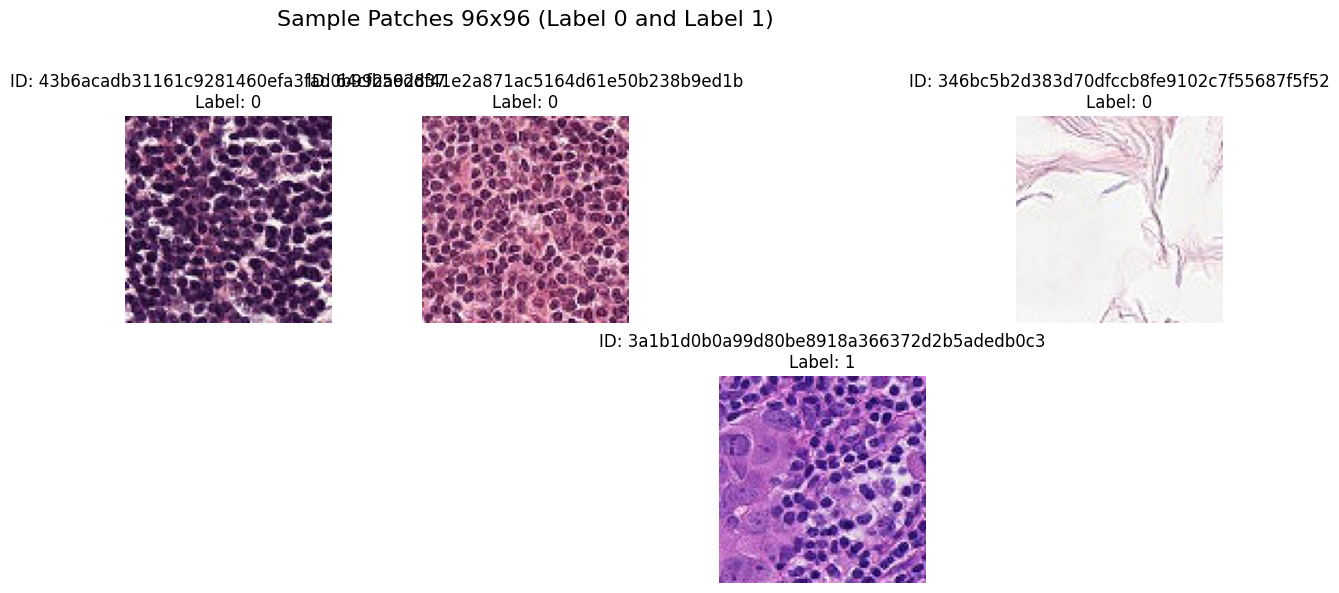


--- 4.1. Pre-processing Setup (Plan) ---
Calculated Class Weights: {0: 0.840380267057781, 1: 1.234472659537462}


In [8]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from PIL import Image
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split 
import tensorflow as tf
from tensorflow.keras.applications import ResNet50 # <-- Added for Model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Verify TensorFlow is working
print(f"TensorFlow version: {tf.__version__}")

# Set the base path for the Kaggle Kernel
# The competition data is automatically mounted here
INPUT_DIR = '../data/'
TRAIN_DIR = os.path.join(INPUT_DIR, 'train')
LABEL_FILE = os.path.join(INPUT_DIR, 'train_labels.csv')

# Standard image size for the PCam dataset
IMAGE_SIZE = 96

# --- 2. Data Statistics and Class Distribution (EDA) ---

print("--- 2.1. Load and Inspect Labels ---")
train_df = pd.read_csv(LABEL_FILE)
print(f"Total number of training samples: {len(train_df)}")
print("\nFirst 5 rows of the dataset:")
print(train_df.head())

# Count samples for each class
class_counts = train_df['label'].value_counts()
print("\n--- 2.2. Class Distribution ---")
print(class_counts)

# Visualize Class Distribution
plt.figure(figsize=(6, 5))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Class Distribution: Cancer (1) vs. Non-Cancer (0)')
plt.xlabel('Label (0: Non-Cancer, 1: Cancer)')
plt.ylabel('Number of Samples')
plt.xticks([0, 1], ['Non-Cancer', 'Cancer'])
plt.show()
print("Observation: The data shows a slight class imbalance.")


# --- 3. Image Visualization ---
print("\n--- 3. Image Visualization ---")

# Sample 5 patches for each class
sample_0 = train_df[train_df['label'] == 0]['id'].sample(5, random_state=42).tolist()
sample_1 = train_df[train_df['label'] == 1]['id'].sample(5, random_state=42).tolist()
sample_ids = sample_0 + sample_1

plt.figure(figsize=(15, 6))
plt.suptitle(f"Sample Patches {IMAGE_SIZE}x{IMAGE_SIZE} (Label 0 and Label 1)", fontsize=16)

for i, img_id in enumerate(sample_ids):
    # Construct the image file path
    img_path = os.path.join(TRAIN_DIR, f"{img_id}.tif")
    
    # Get the image label
    label = train_df[train_df['id'] == img_id]['label'].iloc[0]
    
    try:
        img = Image.open(img_path)
        plt.subplot(2, 5, i + 1)
        plt.imshow(img)
        plt.title(f"ID: {img_id}\nLabel: {label}")
        plt.axis('off')
    except FileNotFoundError:
        print(f"Error: Image file not found for ID {img_id}")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# --- 4. Data Pre-processing and Analysis Plan ---

print("\n--- 4.1. Pre-processing Setup (Plan) ---")
# Note: Transfer Learning models (ResNet, VGG) are pre-trained on ImageNet.
# We must normalize the data according to ImageNet statistics for optimal performance.

# Calculate Class Weights for Loss Function (Addressing Imbalance)
# Class weights: Used to penalize errors on the minority class (Cancer - Label 1)
y_train = train_df['label'].values
weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {i: weights[i] for i in range(len(weights))}

print(f"Calculated Class Weights: {class_weights}")



## 2. Model Architecture and Reasoning 

The complexity of histopathological features and the need for resource efficiency in the Kaggle environment necessitate the use of **Transfer Learning** with deep Convolutional Neural Networks (CNNs). We selected and compared two pre-trained architectures—**ResNet50** and **VGG16**—both initialized with **ImageNet weights**.

### 2.1. Primary Model: ResNet50

We adopt **ResNet50** as the primary architecture due to its superior performance characteristics for deep learning tasks:

* **Residual Connections:** ResNet solves the **vanishing gradient problem** in deep networks through its skip connections.  This allows the model to effectively learn the highly abstract and nuanced morphological features of cancer cells without the performance degradation typically seen in older, very deep architectures.
* **Depth and Efficiency:** With 50 layers, ResNet is deep enough to capture multi-scale spatial patterns in the $96 \times 96$ patches, while remaining computationally tractable for the limited GPU time available.

### 2.2. Comparative Model: VGG16

**VGG16** is used as a comparative baseline to quantify the performance gain provided by modern architectures like ResNet.

* **Simple Structure:** VGG's uniform $3 \times 3$ convolution blocks make it straightforward, serving as a reliable benchmark for feature extraction in image classification.

### 2.3. Customized Architecture and Strategy

Both base models are modified and trained using a two-stage strategy tailored for the PCam dataset:

| Component | Detail | Reasoning |
| :--- | :--- | :--- |
| **Input** | $96 \times 96 \times 3$ (RGB) | Matches PCam data dimensions; Normalized by ImageNet stats. |
| **Classification Head** | Global Average Pooling $\rightarrow$ Dense (128 units, ReLU, Dropout 0.5) $\rightarrow$ Output (1 unit, Sigmoid) | Simplifies parameter count and customizes the output for the binary classification task (Cancer vs. Non-Cancer). |
| **Training Phase 1 (Frozen)** | Base layers frozen. Trained for $\sim$5 epochs with $\text{LR} = 10^{-3}$. | **Optimizes Resource Usage:** Freezing the convolutional base saves significant GPU time and memory in the initial phase while training the new classification head. |
| **Training Phase 2 (Fine-Tuning)** | Last layers unfrozen. Trained for $\sim$10-15 epochs with $\text{LR} = 10^{-5}$. | **Maximizes Performance:** Allows the model to adapt its internal feature weights specifically to the unique visual characteristics of histopathology images, balancing generalization and specialization. |

The evaluation will use the **Area Under the ROC Curve (AUC)**, the competition's metric, as it provides a robust measure of performance on imbalanced classification tasks.

In [9]:
# ==============================================================================
# --- 5. Hyperparameters and Data Generator Setup (PHASE 1) ---
# ==============================================================================

# Split dataset for train set / validate set
# Split the dataframe into Training (80%) and Validation (20%)
# Stratify=y_train ensures that both sets maintain the same class ratio to handle imbalance
# We will use the full training set (train_df) for this split
y_full = train_df['label']
X_full = train_df['id']

X_train, X_val, y_train, y_val = train_test_split(
    X_full, y_full, 
    test_size=0.20,      # 20% for validation
    stratify=y_full,     # Crucial for maintaining class balance in both sets
    random_state=42      # For reproducibility
)

# Convert split results back to DataFrames for easier use with ImageDataGenerator
train_df_split = pd.DataFrame({'id': X_train, 'label': y_train}).reset_index(drop=True)
val_df_split = pd.DataFrame({'id': X_val, 'label': y_val}).reset_index(drop=True)

# Add .tif extension to IDs for generator compatibility
train_df_split['id'] = train_df_split['id'].apply(lambda x: x + '.tif')
val_df_split['id'] = val_df_split['id'].apply(lambda x: x + '.tif')

# FIX: Convert both Training and Validation labels to string for class_mode='binary'
train_df_split['label'] = train_df_split['label'].astype(str)
val_df_split['label'] = val_df_split['label'].astype(str)



# Define Hyperparameters for the initial, frozen phase
BATCH_SIZE = 64 
INITIAL_EPOCHS = 8 
LEARNING_RATE_PHASE_1 = 1e-3 # Faster LR for training the new head

# --- 5.1. Data Augmentation and Pre-processing ---

# ResNet50 requires input data to be pre-processed according to its specific function
# This function handles ImageNet normalization internally.
# Keras ImageDataGenerator handles the augmentation and flow from disk efficiently.

datagen_train = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input, # ImageNet Preprocessing
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Validation generator should only perform pre-processing (no augmentation)
datagen_val = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

# --- 5.2. Create Data Generators from DataFrames ---

train_generator = datagen_train.flow_from_dataframe(
    dataframe=train_df_split,
    directory=TRAIN_DIR,
    x_col='id',
    y_col='label',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary', # For binary classification
    validate_filenames=False, # Optional, for speed
    seed=42
)

validation_generator = datagen_val.flow_from_dataframe(
    dataframe=val_df_split,
    directory=TRAIN_DIR,
    x_col='id',
    y_col='label',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    validate_filenames=False,
    shuffle=False, # Important for consistent validation checks
    seed=42
)

# --- 5.3. Define Callbacks ---
# We track validation AUC since it's the competition metric

checkpoint_filepath = 'best_model_resnet_phase1.weights.h5'

callbacks = [
    # Save the best model weights based on validation AUC
    ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_auc',
        mode='max',
        save_best_only=True,
        verbose=1
    ),
    # Stop training early if validation AUC doesn't improve for 5 epochs
    EarlyStopping(
        monitor='val_auc', 
        patience=5, 
        mode='max',
        verbose=1
    )
]

# ==============================================================================
# --- 6. Model Architecture and Training (ResNet50 - Phase 1: Frozen) ---
# ==============================================================================

def build_resnet_model(input_shape, base_trainable=False):
    """
    Builds the ResNet50 model with a custom classification head.
    :param input_shape: Shape of the input image (H, W, C).
    :param base_trainable: Boolean to set the base model's trainable status.
    """
    # 1. Load Pre-trained Base Model
    base_model = ResNet50(
        weights='imagenet',
        include_top=False, # Exclude the default classification head
        input_shape=input_shape
    )
    
    # 2. Freeze/Unfreeze the Base Model
    base_model.trainable = base_trainable # False for Phase 1
    print(f"ResNet50 Base Model Trainable Status: {base_model.trainable}")

    # 3. Add Custom Classification Head
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(), # Reduces feature maps to a single vector
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid') # Binary Output
    ])
    
    return model

# --- 6.1. Build and Compile Model ---
print("\n--- 6.1. Building ResNet50 Model (Phase 1: Frozen) ---")
model_resnet = build_resnet_model(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), base_trainable=False)

# Compile the model
model_resnet.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE_PHASE_1),
    loss='binary_crossentropy',
    metrics=[
        'accuracy', 
        tf.keras.metrics.AUC(name='auc') # Competition metric
    ]
)

model_resnet.summary()

# --- 6.2. Train Model (Phase 1: Frozen) ---
print("\n--- 6.2. Starting Training (Phase 1: Frozen Base) ---")

history_resnet_phase1 = model_resnet.fit(
    train_generator,
    steps_per_epoch=train_generator.n // BATCH_SIZE,
    epochs=INITIAL_EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // BATCH_SIZE,
    class_weight=class_weights, # Crucial for handling imbalance
    callbacks=callbacks,
    verbose=1
)

# Load the best weights saved during training
model_resnet.load_weights(checkpoint_filepath)
print(f"Loaded best weights from {checkpoint_filepath}")


# ==============================================================================
# --- 7. Plotting Training History ---
# ==============================================================================

def plot_training_history(history, model_name):
    """
    Plots the training and validation Loss and AUC over epochs.
    """
    # Extract metrics
    history_df = pd.DataFrame(history.history)
    epochs = history_df.index.to_numpy() + 1
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f'Training and Validation Metrics for {model_name}', fontsize=16)

    # Plot Loss
    ax1.plot(epochs, history_df['loss'], label='Training Loss', marker='o')
    ax1.plot(epochs, history_df['val_loss'], label='Validation Loss', marker='o')
    ax1.set_title('Loss Over Epochs')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss (Binary Crossentropy)')
    ax1.legend()
    ax1.grid(True)
    
    # Plot AUC
    ax2.plot(epochs, history_df['auc'], label='Training AUC', marker='o')
    ax2.plot(epochs, history_df['val_auc'], label='Validation AUC', marker='o')
    ax2.set_title('AUC Over Epochs')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('AUC Score')
    ax2.legend()
    ax2.grid(True)
    
    plt.show()

# --- 7.1. Visualize Phase 1 Results ---
plot_training_history(history_resnet_phase1, "ResNet50 - Phase 1 (Frozen Base)")

# ==============================================================================
# --- 8. Next Step: Fine-Tuning Preparation ---
# ==============================================================================

print("\n--- 8. Next Step: Fine-Tuning Preparation ---")
print(f"Best Validation AUC achieved in Phase 1: {max(history_resnet_phase1.history['val_auc']):.4f}")
print("Observation from Charts:")
print("- If Training Loss > Validation Loss, the model might be underfitting/needs more capacity.")
print("- If Training Loss << Validation Loss, the model is overfitting the new head (unlikely in Phase 1).")
print("- We now proceed to Phase 2 (Fine-Tuning) with a much smaller Learning Rate to adapt the ResNet base layers.")

Found 176020 non-validated image filenames belonging to 2 classes.
Found 44005 non-validated image filenames belonging to 2 classes.

--- 6.1. Building ResNet50 Model (Phase 1: Frozen) ---
ResNet50 Base Model Trainable Status: False


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 3, 3, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)


--- 6.2. Starting Training (Phase 1: Frozen Base) ---


FileNotFoundError: [Errno 2] No such file or directory: '../data/train/a308c06512e1d740a5c727bfaddb589ba5a55577.tif'